In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import scipy.optimize

In [2]:
DATA_DIR = "../data/netac/quartz64b/"

In [3]:
def fit_linear_knee(X, y):  
    
    def fit_linear_zero(X, y):
        X = np.atleast_2d(X)
        y = np.atleast_1d(y)
        a, residual, *_ = np.linalg.lstsq(X.T, y, rcond=None)
        return a, residual
    
    def fit_linear(X, y):
        X = np.atleast_2d(X)
        y = np.atleast_1d(y)
        X = np.vstack([X, np.ones(X.shape[1])])
        a, residual, *_ = np.linalg.lstsq(X.T, y, rcond=None)
        return a, residual

    def fit_linear_combined(X, y, knee_idx):
        return (fit_linear_zero(X[:knee_idx], y[:knee_idx]), fit_linear(X[knee_idx:], y[knee_idx:]))
    
    def cost_function(knee_idx):
        knee_idx = int(knee_idx)
        (_, cost1), (_, cost2) = fit_linear_combined(X, y, knee_idx)
        cost = (cost1 * knee_idx / y.shape[0] + cost2 * (y.shape[0] - knee_idx) / y.shape[0])
        return cost
    
    knee_idx = scipy.optimize.minimize_scalar(cost_function,
                                              bounds=(3, y.shape[0]-3),
                                              bracket=(3, y.shape[0]-3))
    
    (l1, _), (l2, _) = fit_linear_combined(X, y, int(knee_idx.x))
    return l1, l2

In [4]:
def load(filename):
    return pd.read_table(filename, sep="\s+", header=None, names=["time","bytes"])

In [5]:
cached = [load(x) for x in glob(DATA_DIR + "write_cached*.dat")]

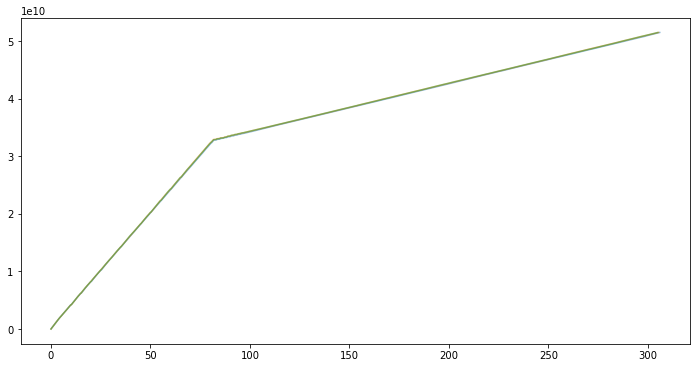

In [6]:
plt.figure(figsize=(12, 6))
for i in cached:
    plt.plot(i.time / 1e6, i.bytes, alpha=0.5)

In [7]:
direct = [load(x) for x in glob(DATA_DIR + "write_direct*.dat")]

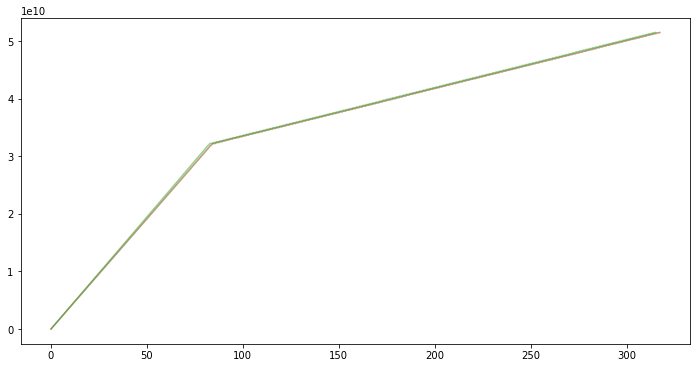

In [8]:
plt.figure(figsize=(12, 6))
for i in direct:
    plt.plot(i.time / 1e6, i.bytes, alpha=0.5)

In [9]:
#advice = [load(x) for x in glob(DATA_DIR + "write_advice*.dat")]

In [10]:
#plt.figure(figsize=(12, 6))
#for i in advice:
#    plt.plot(i.time / 1e6, i.bytes, alpha=0.5)

In [11]:
mmap = [load(x) for x in glob(DATA_DIR + "write_mmap*.dat")]

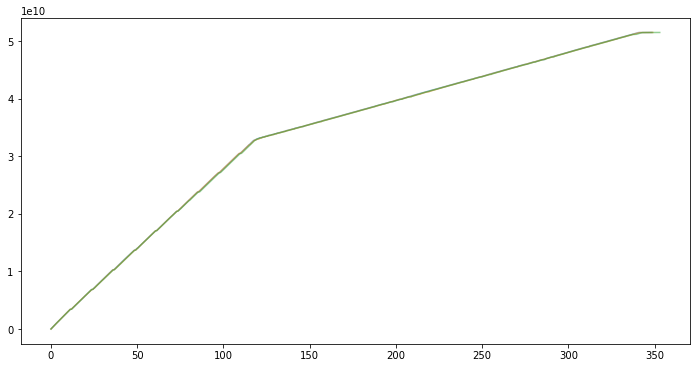

In [12]:
plt.figure(figsize=(12, 6))
for i in mmap:
    plt.plot(i.time / 1e6, i.bytes, alpha=0.5)

In [13]:
uring_cached = [load(x) for x in glob(DATA_DIR + "write_uring_cached*.dat")]

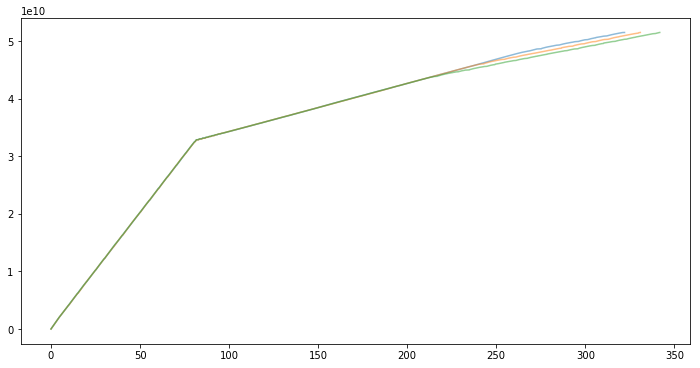

In [14]:
plt.figure(figsize=(12, 6))
for i in uring_cached:
    plt.plot(i.time / 1e6, i.bytes, alpha=0.5)

In [15]:
uring_direct = [load(x) for x in glob(DATA_DIR + "write_uring_direct*.dat")]

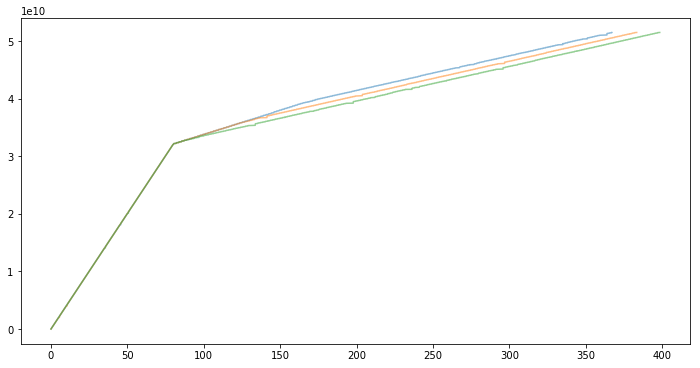

In [16]:
plt.figure(figsize=(12, 6))
for i in uring_direct:
    plt.plot(i.time / 1e6, i.bytes, alpha=0.5)

In [17]:
uring_fixed_direct = [load(x) for x in glob(DATA_DIR + "write_uring_fixed_direct*.dat")]

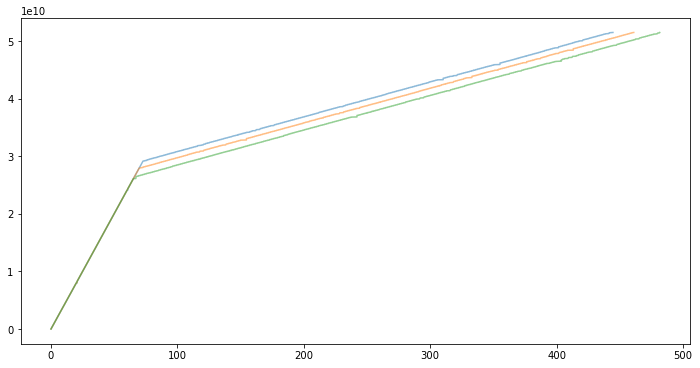

In [18]:
plt.figure(figsize=(12, 6))
for i in uring_fixed_direct:
    plt.plot(i.time / 1e6, i.bytes, alpha=0.5)

In [19]:
uring_fixed_cached = [load(x) for x in glob(DATA_DIR + "write_uring_fixed_cached*.dat")]

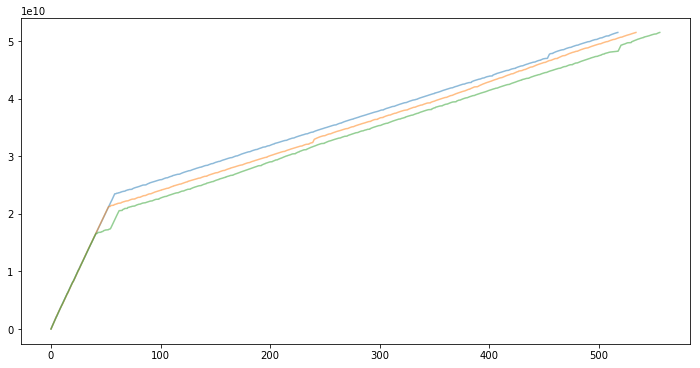

In [20]:
plt.figure(figsize=(12, 6))
for i in uring_fixed_cached:
    plt.plot(i.time / 1e6, i.bytes, alpha=0.5)

In [21]:
cached_fit, *_ = fit_linear_knee(cached[0].time, cached[0].bytes)
direct_fit, *_ = fit_linear_knee(direct[0].time, direct[0].bytes)
#advice_fit, *_ = fit_linear_knee(advice[0].time, advice[0].bytes)
mmap_fit, *_ = fit_linear_knee(mmap[0].time, mmap[0].bytes)
uring_cached_fit, *_ = fit_linear_knee(uring_cached[0].time, uring_cached[0].bytes)
uring_direct_fit, *_ = fit_linear_knee(uring_direct[0].time, uring_direct[0].bytes)
uring_fixed_cached_fit, *_ = fit_linear_knee(uring_fixed_cached[0].time, uring_fixed_cached[0].bytes)
uring_fixed_direct_fit, *_ = fit_linear_knee(uring_fixed_direct[0].time, uring_fixed_direct[0].bytes)

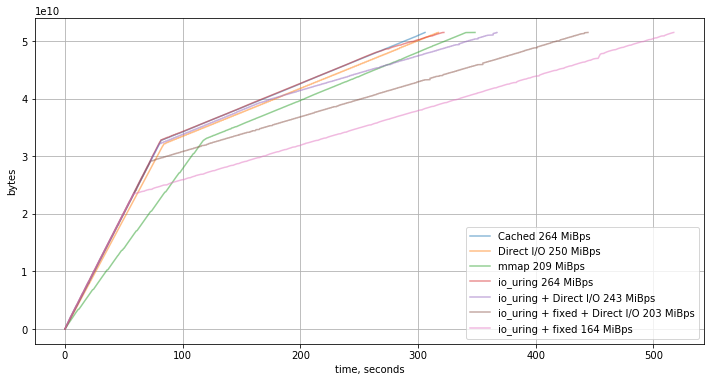

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(cached[0].time / 1e6, cached[0].bytes, alpha=0.5, label="Cached {:.0f} MiBps".format(cached_fit[0] / 2**20 *1e6))
plt.plot(direct[0].time / 1e6, direct[0].bytes, alpha=0.5, label="Direct I/O {:.0f} MiBps".format(direct_fit[0] / 2**20*1e6))
#plt.plot(advice[0].time / 1e6, advice[0].bytes, alpha=0.5, label="Cached + posix_fadvice {:.0f} MiBps".format(advice_fit[0] / 2**20 * 1e6))
plt.plot(mmap[0].time / 1e6, mmap[0].bytes, alpha=0.5, label="mmap {:.0f} MiBps".format(mmap_fit[0] / 2**20 * 1e6))
plt.plot(uring_cached[0].time / 1e6, uring_cached[0].bytes, alpha=0.5, label="io_uring {:.0f} MiBps".format(uring_cached_fit[0] / 2**20 * 1e6))
plt.plot(uring_direct[0].time / 1e6, uring_direct[0].bytes, alpha=0.5, label="io_uring + Direct I/O {:.0f} MiBps".format(uring_direct_fit[0] / 2**20 * 1e6))
plt.plot(uring_fixed_direct[0].time / 1e6, uring_fixed_direct[0].bytes, alpha=0.5, label="io_uring + fixed + Direct I/O {:.0f} MiBps".format(uring_fixed_direct_fit[0] / 2**20 * 1e6))
plt.plot(uring_fixed_cached[0].time / 1e6, uring_fixed_cached[0].bytes, alpha=0.5, label="io_uring + fixed {:.0f} MiBps".format(uring_fixed_cached_fit[0] / 2**20 * 1e6))

#plt.axline((0,0), (1,650e6), linestyle='--', linewidth=0.5, label="www.techpowerup.com")
plt.xlabel("time, seconds")
plt.ylabel("bytes")
plt.legend()
plt.grid()